In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
plt.style.use('seaborn')

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

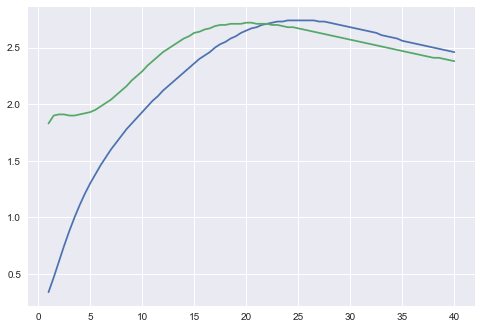

In [5]:
class VAEDataSet(Dataset):
    def __init__(self, file_name):
        self.d = pd.read_csv(file_name, index_col=0).dropna()
        self.tenors = self.d.columns
        self.rates = self.d.values
        self.scaler = StandardScaler()
        self.scaled_d = self.scaler.fit_transform(self.rates)
        self.X = torch.from_numpy(self.scaled_d)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]

ds = VAEDataSet('GiltRates.csv')

plt.plot(ds.tenors.to_numpy().astype(float), ds.rates[0])
plt.plot(ds.tenors.to_numpy().astype(float), ds.rates[-1])

In [6]:
class VariationalEncoder(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_latent):
        super().__init__()
        self.linear = nn.Linear(num_inputs, num_hidden)
        self.linear_mu = nn.Linear(num_hidden, num_latent)
        self.linear_logsigma2 = nn.Linear(num_hidden, num_latent)
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        mu = self.linear_mu(x)
        logsigma2 = self.linear_logsigma2(x)
        sigma = torch.exp(logsigma2 / 2)
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = ((sigma**2 + mu**2 - logsigma2 - 1) / 2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, num_layers, num_inputs, num_hidden, num_latent):
        super().__init__()
        layers = []
        layers.append(nn.Linear(num_latent, num_hidden))
        layers.append(nn.ReLU())
        for _ in range(0, num_layers - 2):
            layers.append(nn.Linear(num_hidden, num_hidden))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(num_hidden, num_inputs))
        self.net = nn.Sequential(*layers)
        
    def forward(self, z):
        return self.net(z)
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_layers, num_inputs, num_hidden, num_latent):
        super().__init__()
        assert num_hidden > 0
        assert num_latent > 0
        
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_latent = num_latent
        
        self.encoder = VariationalEncoder(num_inputs, num_hidden, num_latent)
        self.decoder = Decoder(num_layers, num_inputs, num_hidden, num_latent)
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
    
def train(vae, print_every, seed, lr, gamma, beta):
    vae.train()
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    history = []
    torch.manual_seed(seed)
    prev_loss = None
    for epoch in range(epochs):
        last_lr = scheduler.get_last_lr()
        total_loss = 0.0
        torch.manual_seed(seed)
        np.random.seed(seed)
        for X in data_loader:
            scaling = 1/len(X)
            X_ = vae(X)
            diff = ((X- X_)**2).sum(dim=1)
            loss = (diff + beta * vae.encoder.kl).mean() * scaling
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss
        
        if prev_loss is not None and total_loss > prev_loss:
            scheduler.step()
        prev_loss = total_loss
        if (epoch + 1) % print_every == 0:
            print(f"Epoch: {epoch + 1:4d}, lr: {last_lr[0]:.4e}," f" total_loss: {total_loss:.4e}")
        history.append(total_loss)
    return history

Epoch:   50, lr: 1.3509e-03, total_loss: 1.9705e+01
Epoch:  100, lr: 5.2335e-04, total_loss: 1.2672e+01
Epoch:  150, lr: 1.1973e-04, total_loss: 1.2376e+01
Epoch:  200, lr: 5.7264e-05, total_loss: 1.2300e+01
Epoch:  250, lr: 4.1746e-05, total_loss: 1.2262e+01
Epoch:  300, lr: 3.3814e-05, total_loss: 1.2234e+01
Epoch:  350, lr: 3.3814e-05, total_loss: 1.2206e+01
Epoch:  400, lr: 3.0433e-05, total_loss: 1.2184e+01
Epoch:  450, lr: 3.0433e-05, total_loss: 1.2166e+01
Epoch:  500, lr: 3.0433e-05, total_loss: 1.2150e+01
Epoch:  550, lr: 2.7389e-05, total_loss: 1.2134e+01
Epoch:  600, lr: 2.4650e-05, total_loss: 1.2121e+01
Epoch:  650, lr: 2.4650e-05, total_loss: 1.2110e+01
Epoch:  700, lr: 2.4650e-05, total_loss: 1.2099e+01
Epoch:  750, lr: 2.4650e-05, total_loss: 1.2089e+01
Epoch:  800, lr: 2.4650e-05, total_loss: 1.2080e+01
Epoch:  850, lr: 2.4650e-05, total_loss: 1.2071e+01
Epoch:  900, lr: 2.2185e-05, total_loss: 1.2061e+01
Epoch:  950, lr: 2.2185e-05, total_loss: 1.2053e+01
Epoch: 1000,

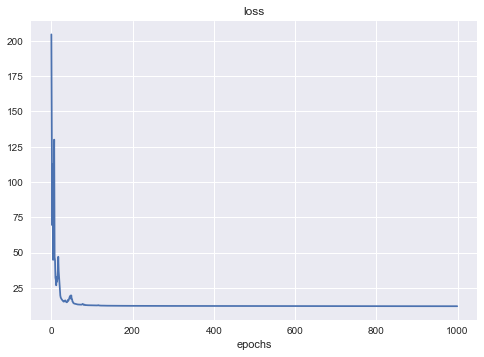

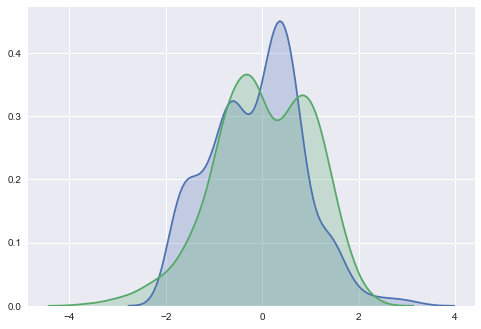

In [37]:
data_loader = torch.utils.data.DataLoader(dataset=ds, batch_size=32)
num_inputs = ds.X.shape[1]
lr = 1e-2
gamma = 0.90
beta = 0.05
epochs = 1000
seed = 567
print_every = 50
num_latent = 2
num_hidden = 32
num_layers = 3
vae = VariationalAutoencoder(num_layers, num_inputs, num_hidden, num_latent)
history = train(vae, print_every, seed, lr, gamma, beta)

plt.plot([x for x in history])
plt.title("loss")
plt.xlabel("epochs")
plt.show()

import seaborn as sns
X = ds.X
C = vae.encoder(X).detach().numpy()
for i in range(C.shape[1]):
    sns.kdeplot(C[:,i], shade=True)

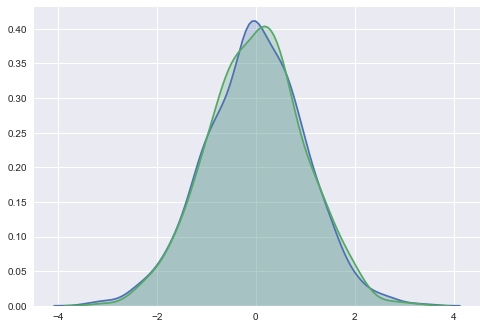

In [212]:
np.random.seed(seed)
offset = 0.0
normal_dist = torch.distributions.Normal(offset,1.0)
Z = normal_dist.sample((len(ds.rates), num_latent))
Z[0] = torch.tensor([offset, offset])
for i in range(Z.shape[1]):
    sns.kdeplot(Z[:,i].detach().numpy(), shade=True)
scaled_p = vae.decoder(Z)

rates = ds.scaler.inverse_transform(scaled_p.detach().numpy())

Text(0.5, 0, 'Days')

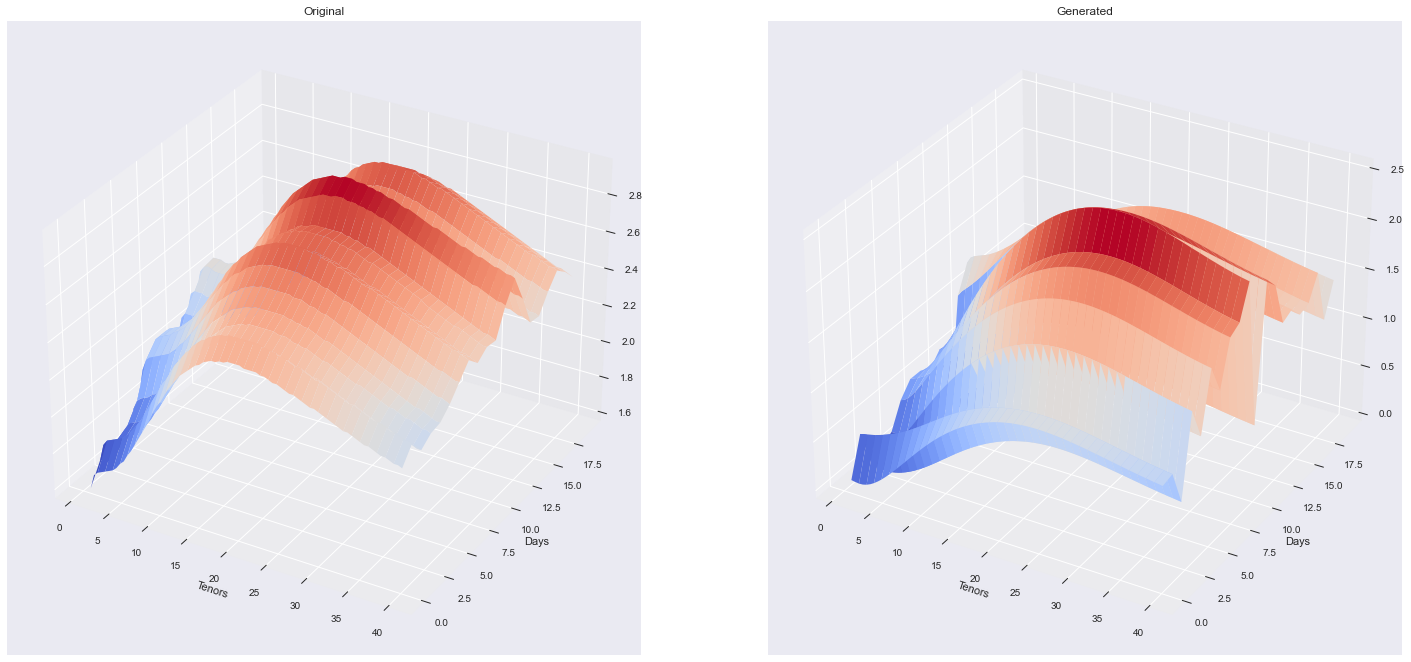

In [213]:
from matplotlib import cm
num_days = 20
fig, ax = plt.subplots(subplot_kw={'projection':"3d"}, ncols=2, figsize=(25,15))
X, Y = np.meshgrid(list(map(float,ds.d.columns)), range(len(ds.rates[-num_days:])))

ax[0].plot_surface(X, Y, ds.rates[-num_days:], cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax[0].set_title("Original")
ax[0].set_xlabel("Tenors")
ax[0].set_ylabel('Days')

ax[1].plot_surface(X, Y, rates[-num_days:], cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax[1].set_title("Generated")
ax[1].set_xlabel("Tenors")
ax[1].set_ylabel('Days')

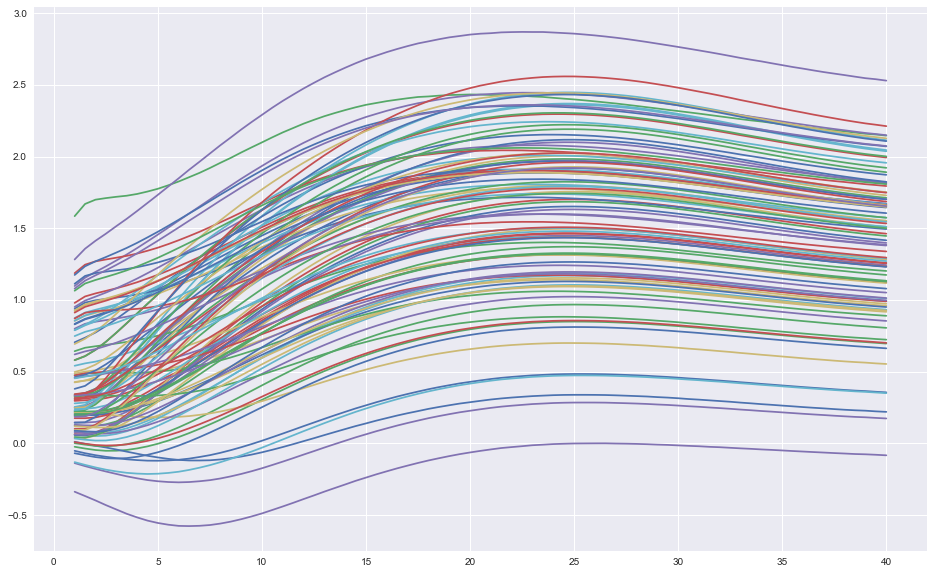

In [214]:
plt.figure(figsize = [16, 10])
sample_rates = []
for i in range(100):
    sample_rates.append(rates[np.random.randint(0,rates.shape[0])])
    plt.plot(ds.tenors.to_numpy().astype(float), rates[np.random.randint(0,rates.shape[0])])

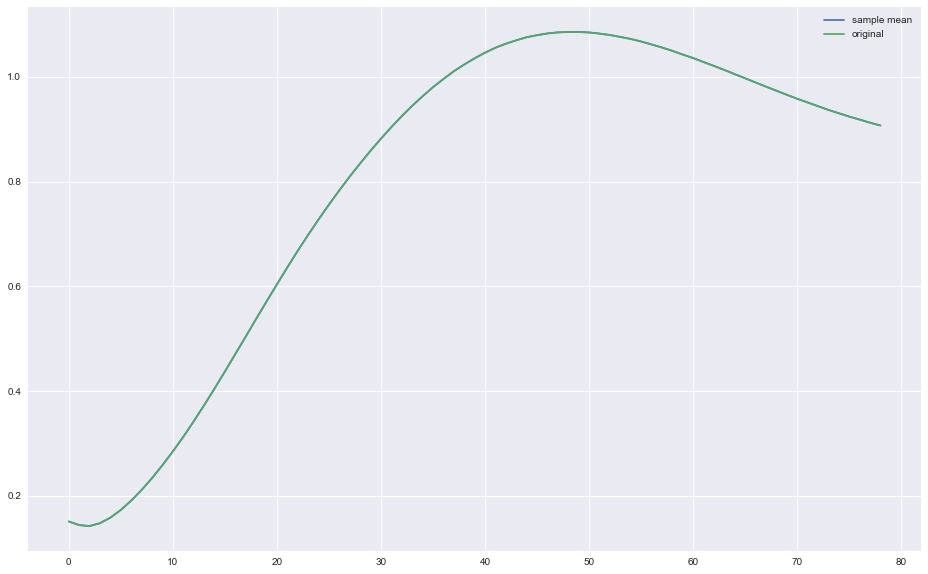

In [303]:
sample_rates = []
for i in range(1000):
    sample_rates.append(rates[np.random.randint(0,rates.shape[0])])
    
plt.figure(figsize = [16, 10])
plt.plot(np.array(sample_rates).mean(0), label='sample mean')
plt.plot(rates[0], label='original')
plt.legend()